# STATISTICAL LEARNING PROJECTON BANK MARKETING DATA 

In [429]:
# Version
exp_version = 'v5.3'  # Experiment version
data_prep = 'full'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_full_all_v5.3


In [447]:
#!pip install imblearn
#!pip install lightgbm
#C:\Users\eomuvwie\OneDrive - IESEG\Stat Machine Learning\Example_v5.3 - Group 1 - Data Processing\MBD2021_InClass Kaggle_2_Modeling_Group1_Py_v5.3 - Data Processing.ipynb
"""
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Gotten from Minh Phan's Kaggle Competition notebook 
    Example_v5.3 - Group 1 - Data Processing
    MBD2021_InClass Kaggle_2_Modeling_Group1_Py_v5.3 - Data Processing.ipynb
    """
# Data exploration
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC 
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

In [328]:
# Reading in the dataset
Bank =  pd.read_csv("./bank_mkt_train.csv", na_values = "unknown") 

In [329]:
# Checking the dataset
Bank.head(5)

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,NaN,married,NaN,NaN,NaN,NaN,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


In [330]:
# Checking the shape of dataset
Bank.shape

(20000, 21)

In [331]:
#Checking the data information
Bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       20000 non-null  int64  
 1   age             19798 non-null  float64
 2   job             19695 non-null  object 
 3   marital         19762 non-null  object 
 4   education       19052 non-null  object 
 5   default         15677 non-null  object 
 6   housing         19356 non-null  object 
 7   loan            19330 non-null  object 
 8   contact         19783 non-null  object 
 9   month           19801 non-null  object 
 10  day_of_week     19815 non-null  object 
 11  campaign        19797 non-null  float64
 12  pdays           19815 non-null  float64
 13  previous        19791 non-null  float64
 14  poutcome        19825 non-null  object 
 15  emp.var.rate    19835 non-null  float64
 16  cons.price.idx  19819 non-null  float64
 17  cons.conf.idx   19803 non-null 

In [332]:
# Checking the statistical summary
Bank.describe()

,client_id,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
count,20000.000000,19798.000000,19797.000000,19815.000000,19791.000000,19835.000000,19819.000000,19803.000000,19796.000000,19816.000000,20000.000000
mean,20683.031650,40.054096,2.580189,961.413222,0.171745,0.088440,93.576248,-40.471661,3.632587,5167.337010,0.113550
std,11898.274235,10.415501,2.787989,189.512187,0.494908,1.573075,0.579978,4.622281,1.730864,72.259166,0.317272
min,2.000000,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,10311.750000,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,20761.500000,38.000000,2.000000,999.000000,0.000000,1.100000,93.798000,-41.800000,4.857000,5191.000000,0.000000
75%,30993.250000,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,41188.000000,98.000000,56.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


## EXPLORATORY DATA ANALYSIS

In [333]:
# Renaming specific column names
Bank['education'] = Bank['education'].replace({'university.degree': 'tertiary', 'high.school': 'secondary', 'basic.9y': 'primary', 'professional.course': 'tertiary', 'basic.4y': 'primary', 'basic.6y': 'primary'})
Bank.head(5)

,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,primary,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,tertiary,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,primary,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,secondary,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,NaN,married,NaN,NaN,NaN,NaN,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


<AxesSubplot:ylabel='client_id'>

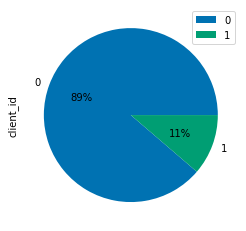

In [334]:
# Creating pie chart to see percentage of subscribers
Bank.groupby(['subscribe']).sum().plot(kind='pie', y='client_id', autopct='%1.0f%%')

<AxesSubplot:ylabel='client_id'>

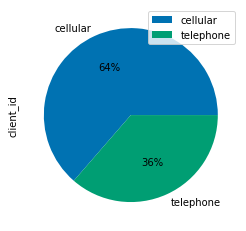

In [335]:
# Creating pie chart to see percentage of contact types
Bank.groupby(['contact']).sum().plot(kind='pie', y='client_id', autopct='%1.0f%%')

<AxesSubplot:ylabel='client_id'>

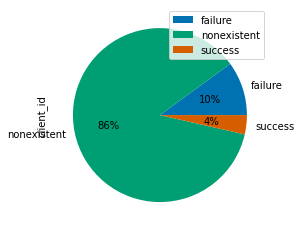

In [336]:
# Creating pie chart for poutcome
Bank.groupby(['poutcome']).sum().plot(kind='pie', y='client_id', autopct='%1.0f%%')

<AxesSubplot:ylabel='client_id'>

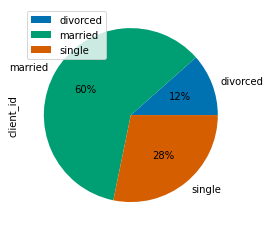

In [337]:
# Creating pie chart for marital status
Bank.groupby(['marital']).sum().plot(kind='pie', y='client_id', autopct='%1.0f%%')

Text(0.5, 1.0, 'EDUCATION COUNT DISTRIBUTION')

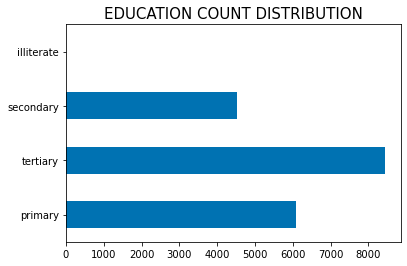

In [338]:
# Creating a bar chart for education
(Bank['education'].value_counts(sort=False).plot.barh().set_title('EDUCATION COUNT DISTRIBUTION', fontsize=15))

<AxesSubplot:ylabel='Frequency'>

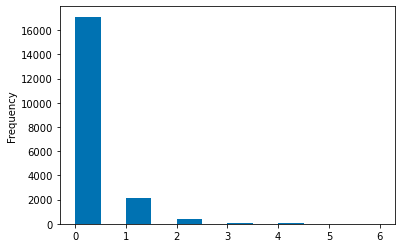

In [339]:
# Creating bar chart for the previous column
(Bank['previous'].plot.hist(bins=12))

<AxesSubplot:ylabel='Frequency'>

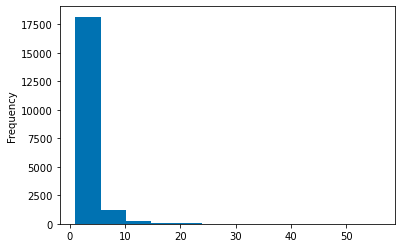

In [340]:
# Creating bar chart for campaign
(Bank['campaign'].plot.hist(bins=12))

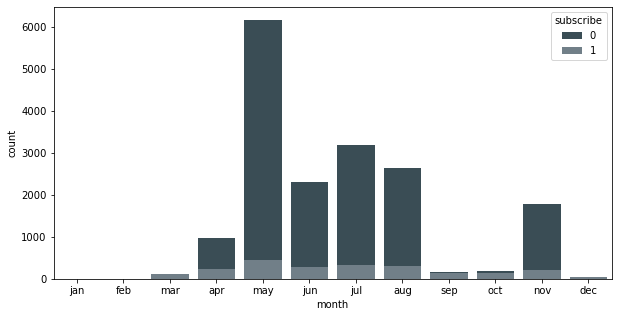

In [341]:
# Visualization for months
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
plt.figure(figsize=(10,5))
sns.countplot(x='month', data=Bank, hue='subscribe', order=months, dodge=False, palette=['#364F59', '#6D808C', '#99ADBF', '#BF9B7A', '#A66F2D']);

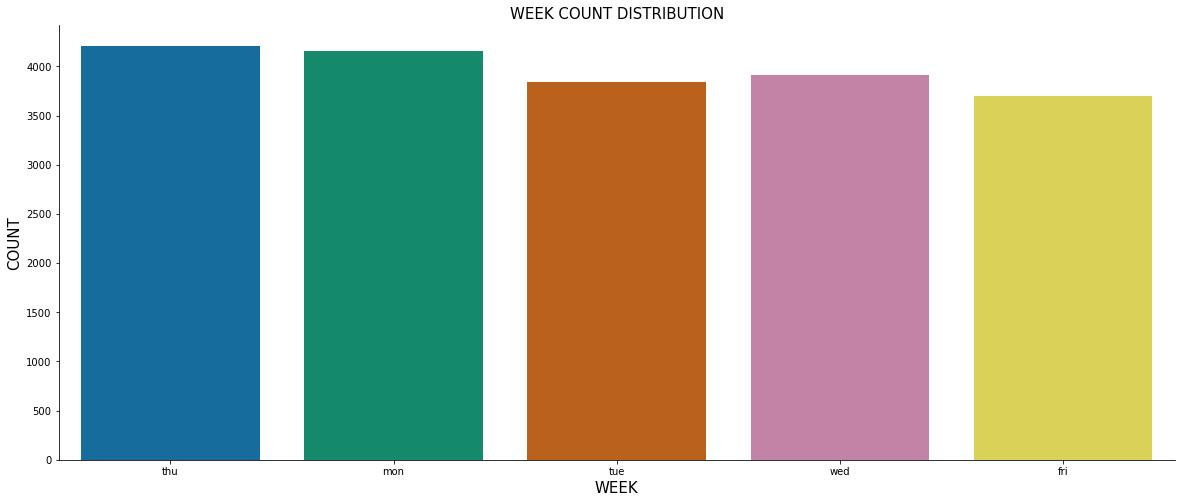

In [342]:
# Visualization of the days of the week
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'day_of_week', data =  Bank)
ax.set_xlabel('WEEK', fontsize=15)
ax.set_ylabel('COUNT', fontsize=15)
ax.set_title('WEEK COUNT DISTRIBUTION', fontsize=15)
sns.despine()

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_core.py:1326: UserWarning:

Vertical orientation ignored with only `x` specified.



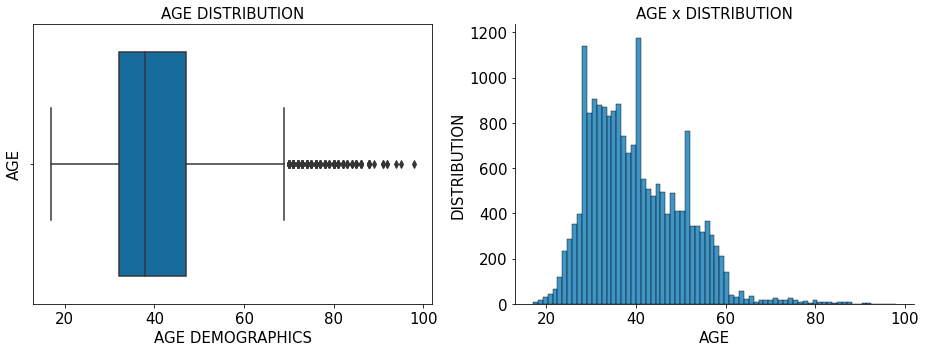

In [343]:
# Creating a graph to check age outlier and distribution
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'age', data = Bank, orient = 'v', ax = ax1)
ax1.set_xlabel('AGE DEMOGRAPHICS', fontsize=15)
ax1.set_ylabel('AGE', fontsize=15)
ax1.set_title('AGE DISTRIBUTION', fontsize=15)
ax1.tick_params(labelsize=15)

sns.histplot(x = Bank['age'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('AGE', fontsize=15)
ax2.set_ylabel('DISTRIBUTION', fontsize=15)
ax2.set_title('AGE x DISTRIBUTION', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

<AxesSubplot:xlabel='age', ylabel='Count'>

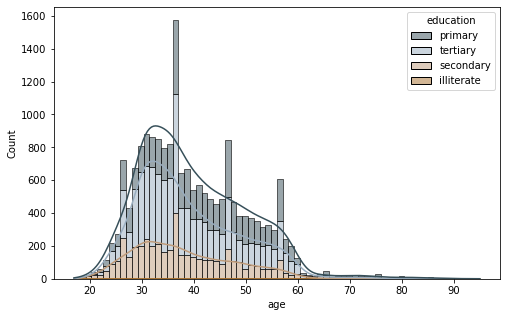

In [344]:
# Plotting the graph for relation between education and age 
plt.figure(figsize=(8,5))
sns.histplot(x='age', data=Bank, hue='education', multiple='stack', kde=True, palette=['#364F59', '#99ADBF', '#BF9B7A', '#A66F2D'])

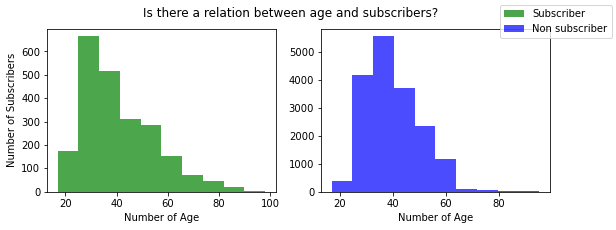

In [345]:
# Splitting the Data into Subscribers and Non Subscribers
S = Bank[Bank["subscribe"] == 1]
NS = Bank[Bank["subscribe"] == 0]

# Define new variables for plotting
x = S["age"]
x1 = NS["age"]
y = S["subscribe"]

# Plotting the graph of the relationship
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].hist(x, color = 'g', alpha=0.7, label = 'Subscriber')
axs[1].hist(x1, color = 'b', alpha=0.7, label = 'Non subscriber')
fig.suptitle('Is there a relation between age and subscribers?')
axs[0].set_xlabel('Number of Age')
axs[1].set_xlabel('Number of Age')
axs[0].set_ylabel('Number of Subscribers')
fig.legend()
plt.show()

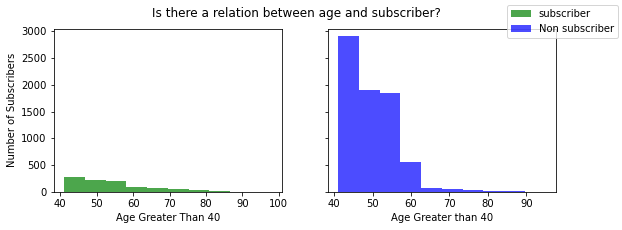

In [346]:
# Splitting the Data into Subscribers and Non-Subscribers, also only select subscribers with age more than 40 
S = Bank[(Bank["subscribe"] == 1) & (Bank["age"] > 40)]
NS = Bank[(Bank["subscribe"] == 0) & (Bank["age"] > 40)]

# Define new variables for plotting
x = S["age"]
x1 = NS["age"]
y = S["subscribe"]

# Plotting the graph to see the relationship between age and subscribers
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey = True)
axs[0].hist(x, color = 'g', alpha=0.7, label = 'subscriber')
axs[1].hist(x1, color = 'b', alpha=0.7, label = 'Non subscriber')
fig.suptitle('Is there a relation between age and subscriber?')
axs[0].set_xlabel('Age Greater Than 40')
axs[1].set_xlabel('Age Greater than 40')
axs[0].set_ylabel('Number of Subscribers')
fig.legend()
plt.show()

<AxesSubplot:xlabel='subscribe'>

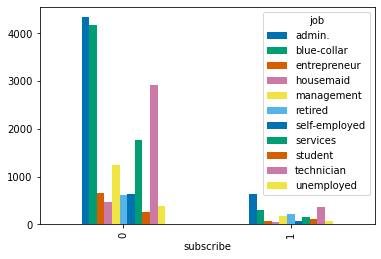

In [347]:
# Creating the graph to check the relationship between job and subscribe
Bank.groupby(['subscribe', 'job']).size().unstack().plot.bar()

<AxesSubplot:xlabel='subscribe'>

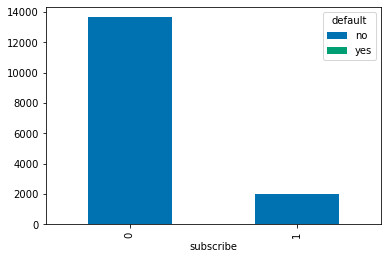

In [348]:
# Creating the graph to check the relationship between default and subscribe
Bank.groupby(['subscribe', 'default']).size().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='subscribe'>

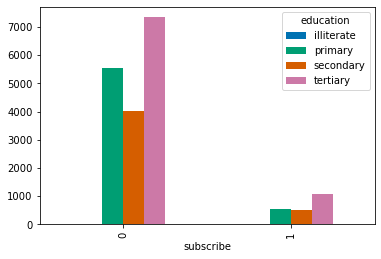

In [349]:
# Creating the graph to check the relationship between education and subscribe
Bank.groupby(['subscribe', 'education']).size().unstack().plot.bar()

<AxesSubplot:xlabel='subscribe'>

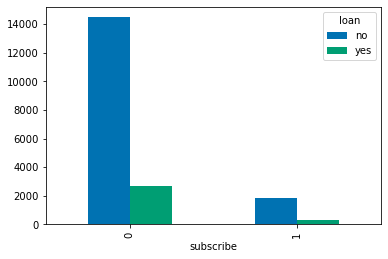

In [350]:
# Creating the graph to check the relationship between loan and subscribe
Bank.groupby(['subscribe', 'loan']).size().unstack().plot.bar()

<AxesSubplot:xlabel='subscribe'>

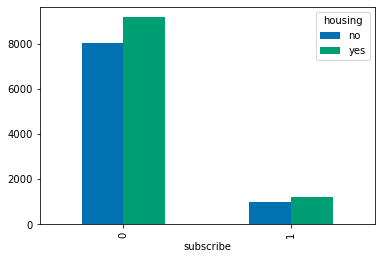

In [351]:
# Creating the graph to check the relationship between housing and subscribe
Bank.groupby(['subscribe', 'housing']).size().unstack().plot.bar()

<AxesSubplot:xlabel='poutcome', ylabel='count'>

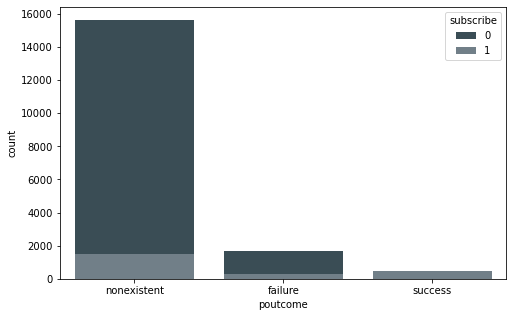

In [352]:
#EDA/eda.ipynb at main · broepke/EDA. (2022). https://github.com/broepke/EDA/blob/main/eda.ipynb
# Creating the graph to check the relationship between poutcome and subscribe
plt.figure(figsize=(8,5))
sns.countplot(x='poutcome', data=Bank, hue='subscribe', dodge=False, palette=['#364F59', '#6D808C', '#99ADBF', '#BF9B7A', '#A66F2D'])

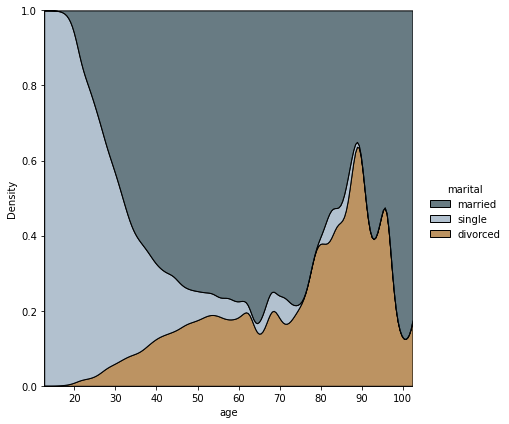

In [353]:
#EDA/eda.ipynb at main · broepke/EDA. (2022). https://github.com/broepke/EDA/blob/main/eda.ipynb
# Creating the graph to check the relationship between age and marital
sns.displot(data=Bank, x="age", hue="marital", kind="kde", 
            height=6, multiple="fill", clip=(0, None), 
            palette=['#364F59', '#99ADBF', '#A66F2D'])

plt.savefig('eda_marital.png', dpi=300);

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

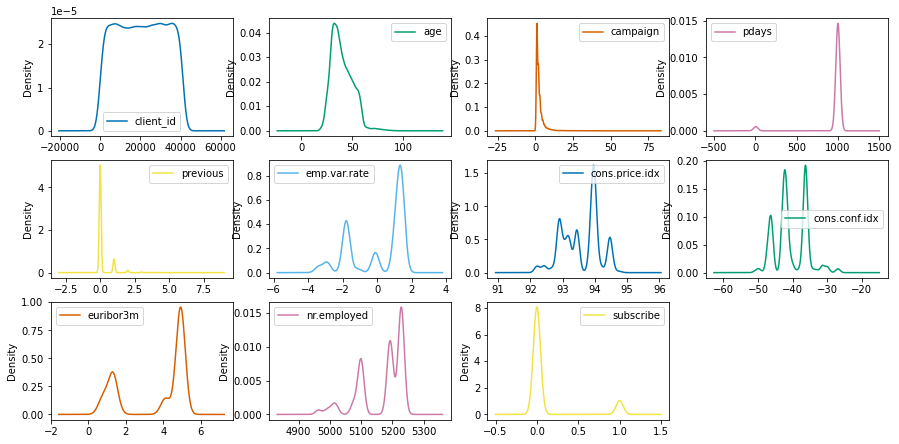

In [354]:
#EDA/eda.ipynb at main · broepke/EDA. (2022). https://github.com/broepke/EDA/blob/main/eda.ipynb
# Creating the graph to check the density of other numerical variables 
Bank.plot(figsize=(15,10), kind='density', subplots=True, layout=(4,4), sharex=False)

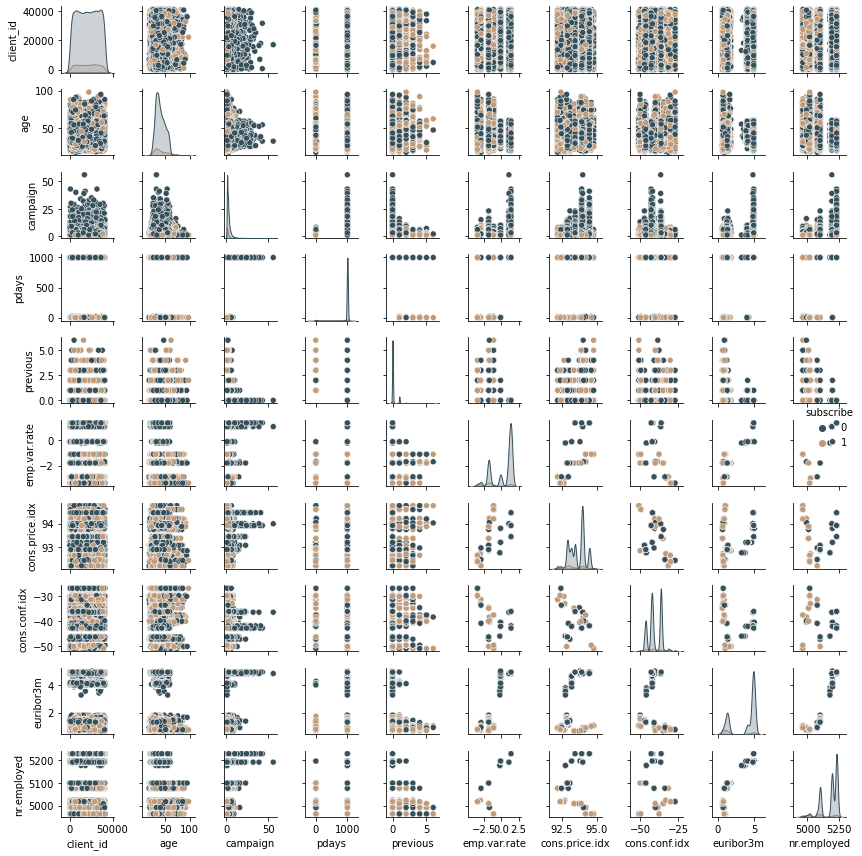

In [355]:
#EDA/eda.ipynb at main · broepke/EDA. (2022). https://github.com/broepke/EDA/blob/main/eda.ipynb
# Creating the graph to check the relationship between variables and subscribe
g=sns.pairplot(Bank, diag_kind = 'auto', hue="subscribe", palette=['#364F59', '#BF9B7A']);
g.fig.set_size_inches(12,12)
    
plt.tight_layout()
plt.savefig('eda_pairs.png', dpi=300);

## DATA CLEANING

. Error Correction
. Missing Values
. Outliers
. Dummy Encoding

In [356]:
# General list of variables
id_var = ["client_id"]  # ID
target_var = ["subscribe"]  # Target get variable
predictors = [v for v in Bank.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week',
            'poutcome']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

In [357]:
# Normalizing class distribution
# By number
print(Bank[target_var].value_counts())

# By percentage
print(Bank[target_var].value_counts(normalize=True))

subscribe
0            17729
1             2271
dtype: int64
subscribe
0            0.88645
1            0.11355
dtype: float64


In [358]:
# Count number of unique values of each variable
vars_nunique = Bank[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, test
Bank = Bank[id_var + num_vars + cat_vars + target_var]

Drop constant variable: []


In [359]:
# Check missing value
print('Train - # NA of num vars:', Bank[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', Bank[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1730
Train - # NA of cat vars: 7904


In [360]:
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = Bank[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = Bank[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train
Bank = Bank[id_var + num_vars + cat_vars + target_var]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []


In [361]:
# List dummary variables to track missing values imputation
na_vars = []

# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(Bank[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train
Bank[impute_vars] = pd.DataFrame(imp.transform(Bank[num_vars]), columns=impute_vars)

In [367]:
# Categorical variables
# Impute missing value using a new category "Missing"
Bank[cat_vars] = Bank[cat_vars].fillna('Missing')

In [368]:
#WillKoehrsen. (2018, May 21). Machine-learning-project-walkthrough/machine learning project part 1.ipynb at master · Willkoehrsen/machine-learning-project-walkthrough. GitHub. https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [369]:
# Calling function on dataset
missing_values_table(Bank)

Your selected dataframe has 30 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [370]:
#WillKoehrsen. (2018, May 21). Machine-learning-project-walkthrough/machine learning project part 1.ipynb at master · Willkoehrsen/machine-learning-project-walkthrough. GitHub. https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb
# Get the columns with > 20% missing
missing_df = missing_values_table(Bank);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 10].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 30 columns.
There are 0 columns that have missing values.
We will remove 0 columns.


In [366]:
# Drop the columns
#Bank = Bank.drop(columns = list(missing_columns))

In [371]:
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(Bank[v])
    sd = np.std(Bank[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (Bank[v] < lower) | (Bank[v] > upper)
    if np.sum(train_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]"
              )

age has # outliers on train, test : 181 [ 0.9 % ]
campaign has # outliers on train, test : 423 [ 2.11 % ]
pdays has # outliers on train, test : 750 [ 3.75 % ]
previous has # outliers on train, test : 519 [ 2.6 % ]


In [267]:
 # Keep top 10 categories and combine minor categories into "Others"
#for v in cat_vars:
   # Find the top 10 categories per cat variable
 #   top10_cat = Bank[v].value_counts()[:10].index.tolist()
     # Impute on train, test
   # Bank[v][-Bank[v].isin(top10_cat)] = 'Others'

In [374]:
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
enc = OrdinalEncoder()
enc.fit(pd.concat([Bank[cat_vars].astype(str)], axis=0))
# Apply on train, test
Bank[cat_vars] = enc.transform(Bank[cat_vars].astype(str))

In [375]:
# Convert bool variable to int
Bank[na_vars] = Bank[na_vars].astype(np.int8)

In [376]:
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['client_id']
# num_vars [ 9 ] : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
# cat_vars [ 10 ] : ['job', 'marital', 'education', 'default', 'housing'] ...
# na_vars [ 9 ] : ['age_na', 'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na'] ...
# target_var [ 1 ] : ['subscribe']


In [271]:
# Sort the data according to the variables list
Bank = Bank[id_var + num_vars + cat_vars + na_vars + target_var]

In [273]:
# Printing out the shape of the data
#print(train.shape)

(20000, 21)


## FEATURE ENGINEERING

Text(0.5, 1.05, 'PEARSON CORRELATION OF FEATURES')

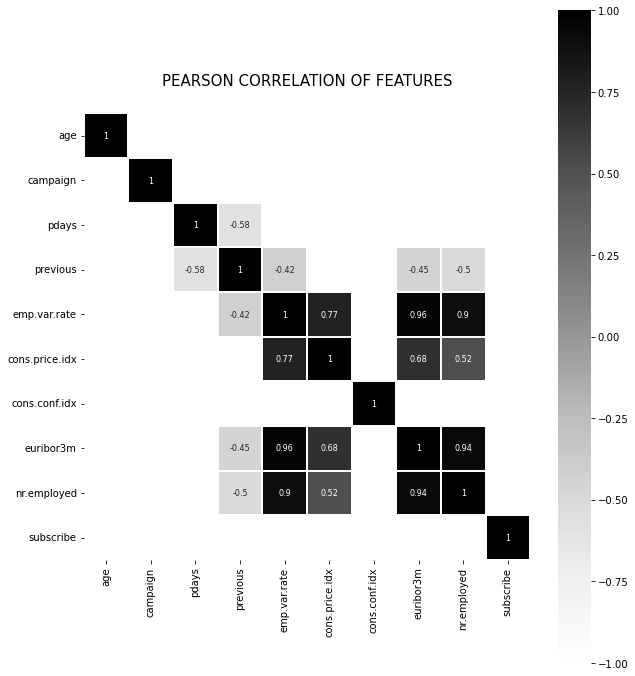

In [383]:
# Correlation Matrix
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Compute the correlation matrix
corr = Bank[num_vars + target_var].corr(method = 'pearson')

# Heatmap
f, ax = plt.subplots(figsize=(10,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='Greys', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

plt.title("PEARSON CORRELATION OF FEATURES", y=1.05, size=15)

In [381]:
# Calculating a Correlation Matrix with Pandas
matrix = Bank[num_vars + target_var].corr().round(2)
matrix = matrix[target_var[0]][:-1].dropna().sort_values(ascending=False)
matrix.head()

# Printing out top 5 and bottom 5 correlations
print("Top 5 vars [+] correlated with target_var :"); print(matrix[matrix > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(matrix[matrix < 0][-5:])

Top 5 vars [+] correlated with target_var :
previous         0.24
cons.conf.idx    0.06
age              0.03
Name: subscribe, dtype: float64
Top 5 vars [-] correlated with target_var :
cons.price.idx   -0.14
emp.var.rate     -0.30
euribor3m        -0.31
pdays            -0.33
nr.employed      -0.35
Name: subscribe, dtype: float64


In [384]:
# variable with significant information.
mutual_info = mutual_info_classif(Bank[cat_vars], Bank[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
poutcome       0.035532
month          0.024021
contact        0.011773
job            0.009138
default        0.007187
housing        0.003160
loan           0.001424
marital        0.001077
education      0.000286
day_of_week    0.000000
dtype: float64


In [386]:
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

In [387]:
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(Bank[[v]], Bank[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(Bank[[v]])
        clf.fit(poly.transform(Bank[[v]]), Bank[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            Bank[poly_vars] = pd.DataFrame(poly.transform(Bank[[v]])[:, 1:], columns=poly_vars)

Variable age AUC vs. AUC poly: 0.49299075190162284 --> 0.5908793357880742


In [388]:
# List of variables to track the value transformation process
trans_vars = []
# Select a cat variable
v = "month"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(Bank.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(Bank[[v]], Bank[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6389734581345676
Best params: {'min_samples_leaf': 200}
Number of leaves: 9


In [389]:
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(Bank[[v]]).toarray()]

print("# original categories:", Bank[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories: 11
# new remapped categories: 9 {4, 6, 8, 9, 10, 12, 13, 15, 16}


In [391]:
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(Bank.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(Bank[[v]], Bank[target_var])
        # Remap the variable on train
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", Bank[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            Bank[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(Bank[[v]]).toarray()]
            

Remapping variable job from 12 to 12 categories
Remapping variable marital from 4 to 4 categories
Remapping variable education from 5 to 4 categories
Remapping variable default from 3 to 2 categories
Remapping variable housing from 3 to 2 categories
Remapping variable contact from 3 to 3 categories
Remapping variable month from 11 to 9 categories
Remapping variable day_of_week from 6 to 2 categories
Remapping variable poutcome from 4 to 3 categories


In [392]:
# Select a num variable
v = "previous"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(Bank.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(Bank[[v]], Bank[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6117530671009248
Best params: {'min_samples_leaf': 200}
Number of leaves: 4


In [393]:
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(Bank[[v]]).toarray()]

print("# original data range: ", [Bank[[v]].min().values[0], Bank[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 6.0]
# new remapped categories: 4 {3, 4, 5, 6}


In [394]:
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(Bank.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(Bank[[v]], Bank[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [Bank[[v]].min().values[0], Bank[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            Bank[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(Bank[[v]]).toarray()]

Discretize variable age from [17.0, 98.0] to 25 categories
Discretize variable campaign from [1.0, 56.0] to 10 categories
Discretize variable pdays from [0.0, 999.0] to 3 categories
Discretize variable previous from [0.0, 6.0] to 4 categories
Discretize variable emp.var.rate from [-3.4, 1.4] to 8 categories
Discretize variable cons.price.idx from [92.201, 94.767] to 14 categories
Discretize variable cons.conf.idx from [-50.8, -26.9] to 15 categories
Discretize variable euribor3m from [0.634, 5.045] to 47 categories
Discretize variable nr.employed from [4963.6, 5228.1] to 9 categories
Discretize variable age^2 from [289.0, 9604.0] to 25 categories
Discretize variable age^3 from [4913.0, 941192.0] to 25 categories


In [395]:
# Select a num variable
v = "age"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(Bank[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10


array([array([17., 28., 31., 33., 36., 38., 41., 45., 49., 55., 98.])],
      dtype=object)

In [396]:
# Apply the binning to a variable
binef_v = est.transform(Bank[[v]])
pd.DataFrame(binef_v).value_counts().sort_index()

0.0    1552
1.0    1984
2.0    1784
3.0    2554
4.0    1625
5.0    2131
6.0    2151
7.0    1911
8.0    2270
9.0    2038
dtype: int64

In [397]:
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(Bank[[v]])
        # Bin the variable on train
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            Bank[binef_var] = est.transform(Bank[[v]])

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning:

Bins whose width ar

In [398]:
# Select a variable
v = "age"

# Binning values of a variable into new groups using equal width approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(Bank[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10


array([array([17. , 25.1, 33.2, 41.3, 49.4, 57.5, 65.6, 73.7, 81.8, 89.9, 98. ])],
      dtype=object)

In [399]:
# Apply the binning to a variable
binew_v = est.transform(Bank[[v]])
pd.DataFrame(binew_v).value_counts().sort_index()

0.0     804
1.0    5386
2.0    6055
3.0    3858
4.0    2847
5.0     750
6.0     156
7.0      96
8.0      41
9.0       7
dtype: int64

In [400]:
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(Bank[[v]])
        # Bin the variable on train
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            Bank[binew_var] = est.transform(Bank[[v]])

In [401]:
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 41


In [402]:
# Arrange the data columns
Bank = Bank[id_var + num_vars + cat_vars + na_vars + target_var]
print(Bank.shape)

(20000, 73)


In [403]:
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

In [409]:
# Select a cat variable
v = "job"

# Build the dummy encoding on [Var194]
enc = OneHotEncoder(drop="first", handle_unknown="error")
enc.fit(pd.concat([Bank[[v]]], axis=0))
enc.categories_

[array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])]

In [ ]:
# Transform a categorical variable
dummy_v = enc.transform(Bank[[v]])
dummy_v.toarray()

In [410]:
# TODO: More efficient implementation
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([Bank[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(Bank[cat_vars])

In [411]:
# Select a variable
v = "job"

# Find the incidence rates per category of a categorical variable
tb = pd.pivot_table(Bank, values=target_var, index=v, aggfunc=np.mean).reset_index()
tb.columns = [v, v + "_icd"]
tb

,job,job_icd
0,0.0,0.121311
1,1.0,0.128818
2,2.0,0.068881
3,3.0,0.089385
4,4.0,0.106870
5,5.0,0.123944
6,6.0,0.252111
7,7.0,0.096542
8,8.0,0.081547
9,9.0,0.313776


In [412]:
# Add/join the incidence variable
pd.merge(Bank[[v]], tb, on=v).head()

,job,job_icd
0,5.0,0.123944
1,5.0,0.123944
2,5.0,0.123944
3,5.0,0.123944
4,5.0,0.123944


In [413]:
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(Bank, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        Bank[icd_var] = pd.merge(Bank[[v]], tb, on=v)[icd_var]


In [414]:
# Select a variable
v = "job"

# Find the incidence rates per category of a categorical variable
# Add +1 before calculating the log to avoid +/-Inf
tb = Bank[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
e = 1e-10  # Small value
tb[v + "_woe"] = np.log((tb[1] + e) / (tb[0] + e))
tb

subscribe,job,0,1,job_woe
0,0.0,268,37,-1.980069
1,1.0,4335,641,-1.911447
2,2.0,4177,309,-2.604007
3,3.0,652,64,-2.321161
4,4.0,468,56,-2.123117
5,5.0,1244,176,-1.955603
6,6.0,620,209,-1.087385
7,7.0,627,67,-2.236254
8,8.0,1757,156,-2.421507
9,9.0,269,123,-0.782527


In [415]:
# Add/join the WoE variable
pd.merge(Bank[[v]], tb[[v, v + "_woe"]], on=v).head()

,job,job_woe
0,5.0,-1.955603
1,5.0,-1.955603
2,5.0,-1.955603
3,5.0,-1.955603
4,5.0,-1.955603


In [416]:
# TODO: More efficient implementation
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = Bank[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train
        Bank[woe_var] = pd.merge(Bank[[v]], tb[[v, woe_var]], on=v)[woe_var]

In [417]:
# Drop cat vars
if drop_cat_vars:
    Bank = Bank.drop(cat_vars, axis=1)
    cat_vars = []

In [418]:
 # Add dummy variables
if enable_repr_dummy:
    Bank = pd.concat([Bank, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy

In [419]:
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))
    

Represented cat variables with # new num variables : 494


In [420]:
# Arrange the data columns
Bank = Bank[id_var + num_vars + cat_vars + na_vars + target_var]
print(Bank.shape)

(20000, 516)


In [421]:
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(Bank[[v]])
        # Apply on train, test
        Bank[v] = scaler.transform(Bank[[v]])

In [422]:
# List of all predictors
predictors = num_vars + cat_vars + na_vars

In [424]:
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(Bank[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
Bank = Bank.drop(const_vars, axis=1)

Drop # constant vars : 0


In [425]:
# Count the duplicated vars
dup_vars = Bank[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 137


In [426]:
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
Bank = Bank[id_var + predictors + target_var]


In [427]:
# Print out the data to check
print(Bank.shape)

(20000, 379)


In [431]:
# Save to pickle format
Bank.to_pickle("./train_processed" + fname + ".pkl")

# SELECTION OF VARIABLES

In [432]:
#fname = '_std_all_v5.1'
Bank = pd.read_pickle("./train_processed" + fname + ".pkl")

In [433]:
# Create several lists to handle variables
id_var = ['client_id']
target_var = ['subscribe']
predictors = [v for v in Bank.columns if v not in id_var + target_var]

In [434]:
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

In [435]:
# Calculate Fisher Score for all variable
fs = FisherScore(Bank, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

,predictor,fisherscore
8,nr.employed,0.738579
7,euribor3m,0.701092
4,emp.var.rate,0.669549
200,x33_4.0,0.596566
269,x47_9.0,0.580713


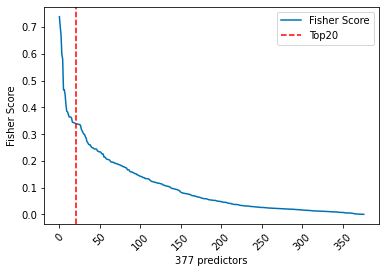

In [436]:
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

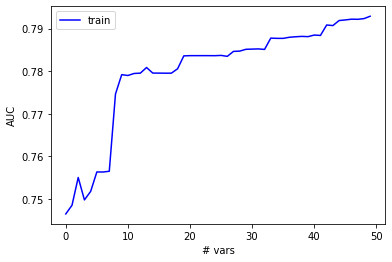

In [437]:
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, Bank[top_n_predictors], Bank[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train'])
plt.show()

In [438]:
# Select the top variables based on Fisher Score
n_top_fs_vars = 50  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50


array(['nr.employed', 'euribor3m', 'emp.var.rate', 'x33_4.0', 'x47_9.0',
       'pdays', 'x21_4', 'x9_3.0', 'x37_4.0', 'previous', 'x32_1.0',
       'x9_2.0', 'x23_14', 'x48_1.0', 'x27_16', 'x48_8.0', 'x21_3',
       'x33_2.0', 'x24_21', 'x6_2.0', 'x23_13', 'x35_5.0', 'x25_20',
       'x37_3.0', 'x27_13', 'x6_1.0', 'x46_3.0', 'x46_4.0', 'x46_6.0',
       'x45_6.0', 'x45_7.0', 'x22_6', 'x27_8', 'cons.price.idx',
       'x44_3.0', 'x46_8.0', 'x36_5.0', 'x27_9', 'x23_5', 'x23_8',
       'x27_6', 'x25_23', 'x7_7.0', 'x27_7', 'x24_5', 'x25_17', 'x19_48',
       'x43_3.0', 'x24_25', 'x3_1.0'], dtype=object)

# MODELLING

In [449]:
from sklearn.svm            import SVC
# Instanciate the models we want to try and create a models dictionary
tree         = DecisionTreeClassifier()
linear     = LinearRegression()
randomForest = RandomForestClassifier(n_estimators = 25, n_jobs=-1)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)


models = {"tree"         :tree,
         "linear"     :linear,
          "randomForest" :randomForest,
         "boostedTree"  :boostedTree,
          "svm"          :svm
         }

In [450]:
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs

# Prepare the data according to the selected set of variables
if var_set == 'all':
    X = Bank[predictors]
elif var_set == 'fs':
    X = Bank[top_fs_vars]
elif var_set == 'pca':
    X = train_pca
y = Bank[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)


(20000, 50)
_full_fs50_v5.3


In [456]:
for model in models:
    models[model].fit(X,y)
    print(f"{model} has been trained successfully")
    
performances_train = {}
performances_test = {}

for model in models:
    predictions   = models[model].predict(X)
    probabilities = pd.DataFrame(models[model].predict(X))[10]
    accuracy      = accuracy_score(y,predictions)
    auc           = roc_auc_score(array(y),array(probabilities))

    performances_train[model] = {"Accuracy":accuracy,"AUC":auc}

for model in models:
    predictions   = models[model].predict(X)
    probabilities = pd.DataFrame(models[model].predict(X))[10]
    accuracy      = accuracy_score(y,predictions)
    auc           = roc_auc_score(array(y),array(probabilities))

    performances_test[model] = {"Accuracy":accuracy,"AUC":auc}

tree has been trained successfully
linear has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully


KeyError: 10

In [457]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X)
    model_mae = mae(y, model_pred)
    
    # Return the performance metric
    return model_mae

In [458]:
#printing performance accuracy
pd.DataFrame(performances_train)

""


In [459]:
#printing performance accuracy
pd.DataFrame(performances_test)

""
